Key points:

- Kmeans (elbow plot & silhouette_score)
- PCA
- normalize
- itertools
- **Recommendation algorithem:**
     - similarity matrix: 
             1) |U|*|I|
             2) Normalize
     - use PCA to find the first n components
     - use kmeans to find the best k
     - clustering and visualization

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import itertools
import re

# Load Dataset

In [2]:
item = pd.read_csv('../DS_Challenges/Clustering_Grocery_Items/item_to_id.csv')
transaction = pd.read_csv('../DS_Challenges/Clustering_Grocery_Items/purchase_history.csv')

In [3]:
item.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [4]:
transaction.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [5]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [6]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [7]:
# check unique values
len_item = len(item['Item_id'].unique())
print(f'item_id \t {len_item}')
len_user=len(transaction['user_id'].unique())
print(f'user_id \t {len_user}')

item_id 	 48
user_id 	 24885


# Data Processing

In [8]:
# transform 1 ('id') column to several columns
transaction_new = transaction.drop(columns='id').join(transaction['id'].str.split(',',expand = True))

In [9]:
%%time
# transform columns names from ids to items
user_id = transaction['user_id'].unique()
data = pd.DataFrame(0, index = user_id, columns = range(1,len_item+1))
i = 0
for user in transaction_new.user_id:
    for item in transaction_new.loc[i][1:]:
        if pd.isnull(item):
            continue
        else:
            item = int(item)
            data.loc[user,item]=data.loc[user,item]+1
    i = i+1

CPU times: user 43.2 s, sys: 249 ms, total: 43.5 s
Wall time: 43.4 s


In [10]:
data

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
222087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1343649,0,1,0,0,0,2,1,0,0,0,...,1,0,0,0,0,0,0,1,2,1
404134,2,0,0,1,0,0,0,0,2,1,...,0,0,0,1,2,0,0,1,1,0
1110200,0,1,1,0,0,1,0,0,1,0,...,1,1,0,0,1,0,0,1,2,1
224107,2,2,1,1,1,1,1,1,3,0,...,0,2,0,1,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755085,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
922812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1055933,0,0,1,0,0,0,0,0,1,1,...,0,0,1,0,1,1,1,0,0,0
724925,1,1,1,1,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0


In [11]:
# Other solution to transform data
# ref: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

# get user_item count matrix
user_item_count = transaction.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

### Find the customer who bought the most items overall in her lifetime.

In [12]:
user_count = user_item_count.sum(axis = 1).\
                            reset_index().\
                            sort_values(by = 0,ascending = False).\
                            rename(columns = {0:'count'})
user_count.head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


### For each item, the customer who bought that product the most

In [13]:
def item_most_user(df):
    """ find the users who bought the item mostly """
    max_count = df['count'].max()
    max_user = df.loc[df['count']==max_count,'user'].values
    return pd.Series([max_user, max_count])

In [15]:
item = pd.read_csv('../DS_Challenges/Clustering_Grocery_Items/item_to_id.csv')

In [16]:
item_user_most = data.unstack().reset_index().\
                rename(columns = {'level_0':'item','level_1':'user',0:'count'}).\
                groupby('item').\
                apply(item_most_user).\
                reset_index().\
                rename(columns = {0:'user_id',1:'count'})
                
item_user_most = item_user_most.merge(item, left_on = 'item', right_on = 'Item_id').drop(columns = 'item')
item_user_most.head()

,user_id,count,Item_name,Item_id
0,"[31625, 540483, 68836, 1301034, 1091637]",4,sugar,1
1,"[31625, 269335]",5,lettuce,2
2,"[1433188, 154960, 593439, 1147269]",4,pet items,3
3,"[432842, 73071, 5289]",3,baby items,4
4,"[397623, 414416, 1392068, 217277]",3,waffles,5


# Question 2

### Cluster items based on user co-purchase history

In [17]:
# step 1: build item-item similarity matrix
# A is |U|*|I|, and each item is normalized
A = normalize(data.values,axis = 0)
item_item_similarity = A.T.dot(A)
item_item_similarity = pd.DataFrame(item_item_similarity, columns = range(1,49),index = range(1,49))
item_item_similarity.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [18]:
# step 2: # rotate by PCA, making it easier to be visualized later
pca = PCA()
items_rotated = pca.fit_transform(item_item_similarity)
items_rotated = pd.DataFrame(items_rotated,
                             index=data.columns,
                             columns=["pc{}".format(index+1) for index in range(item.shape[0])])

In [19]:
items_rotated

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48
1,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,...,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,1.001741e-16
2,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,...,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,1.001741e-16
3,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,...,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,1.001741e-16
4,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,...,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,1.001741e-16
5,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,...,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,1.001741e-16
6,0.312811,-0.036128,0.044851,0.017309,-0.035048,0.080819,-0.047894,-0.021530,0.119243,0.409097,...,-0.020227,0.037458,-0.003532,-0.068856,0.111363,0.038920,-0.179474,0.195229,-0.039911,1.001741e-16
7,-0.550273,-0.188354,0.058120,0.381101,-0.032518,-0.001882,-0.036626,-0.035533,-0.078704,0.033615,...,-0.003264,0.000230,-0.004935,0.009531,0.007640,0.003959,0.010467,0.000722,0.013446,1.001741e-16
8,-0.052373,0.402611,-0.084719,0.101044,0.061785,0.033619,-0.072494,-0.017836,-0.039679,0.006366,...,0.005499,-0.024467,-0.008533,-0.014347,0.004348,-0.003086,0.009040,-0.013534,-0.003083,1.001741e-16
9,0.337225,-0.088904,-0.039285,-0.046014,-0.062167,0.323283,0.195053,-0.089987,-0.061351,-0.085907,...,0.005030,0.248475,0.074118,-0.045950,-0.022483,-0.111802,-0.022843,-0.095708,0.006773,1.001741e-16
10,0.353093,0.000351,0.014369,-0.014293,-0.208917,-0.091994,-0.284679,-0.144108,-0.051950,-0.104297,...,-0.131877,0.051936,0.032112,0.043657,0.236794,0.033620,0.075691,0.145794,-0.071018,1.001741e-16


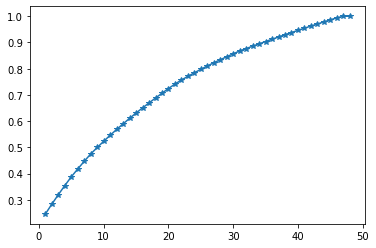

In [20]:
# show the total variance which can be explained by first K principle components
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

In [21]:
item = item.set_index('Item_id')

In [22]:
def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        print("*********** Label [{}] ***********".format(label))
        names = item.loc[grp.index,"Item_name"]
        for index, name in enumerate(names):
            print("\t<{}> {}".format(index+1,name))

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid,"pc1"]
        y = items_rotated.loc[itemid,"pc2"]
        name = item.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)

    # plt.legend(loc="best")

In [23]:
def cluster(n_clusters,n_components=48):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print("first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca.explained_variance_ratio_[:n_components])))

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :n_components])

    # display results
    show_clusters(items_rotated, kmeans.labels_)

In [24]:
# step 3: choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))

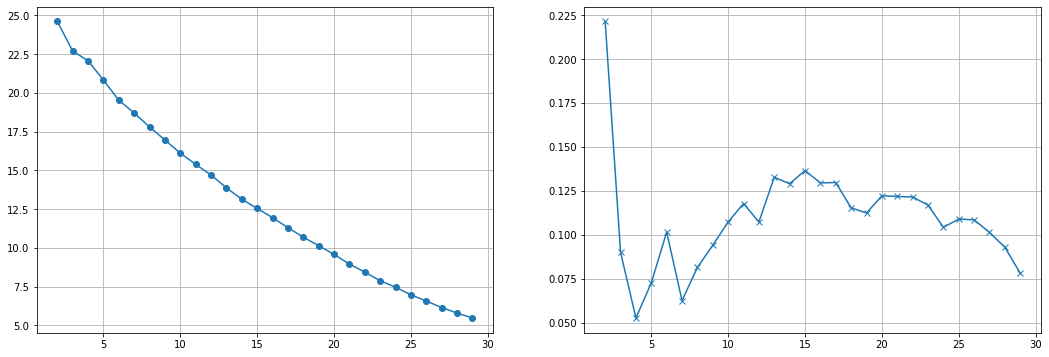

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
ax[0].plot(range(2,30), inertias, 'o-', label='Sum of Squared Distances')# want to use elbow method to find best k
ax[0].grid(True)
ax[1].plot(range(2,30), silhouettes, 'x-', label='Silhouette Coefficient')# the higher the better
ax[1].grid(True)

based on above plots, ** either elbow method nor silhouette_score can give better hint about the number of clusters **. I decide to try multiple K, and choose the best one according to common sense.

first 48 PC explain 100.0% variances
*********** Label [0] ***********
	<1> flour
*********** Label [1] ***********
	<1> poultry
	<2> beef
	<3> pork
*********** Label [2] ***********
	<1> sandwich bags
	<2> aluminum foil
	<3> paper towels
	<4> toilet paper
*********** Label [3] ***********
	<1> grapefruit
	<2> cherries
	<3> apples
	<4> berries
	<5> bananas
*********** Label [4] ***********
	<1> butter
	<2> eggs
	<3> milk
	<4> cheeses
	<5> yogurt
*********** Label [5] ***********
	<1> shampoo
	<2> shaving cream
	<3> hand soap
	<4> soap
*********** Label [6] ***********
	<1> bagels
	<2> tortillas
	<3> dinner rolls
	<4> sandwich loaves
*********** Label [7] ***********
	<1> laundry detergent
	<2> dishwashing 
*********** Label [8] ***********
	<1> lettuce
	<2> carrots
	<3> cucumbers
	<4> broccoli
	<5> cauliflower
*********** Label [9] ***********
	<1> frozen vegetables
	<2> ice cream
*********** Label [10] ***********
	<1> waffles
	<2> pasta
*********** Label [11] ***********
	<1> sugar
	

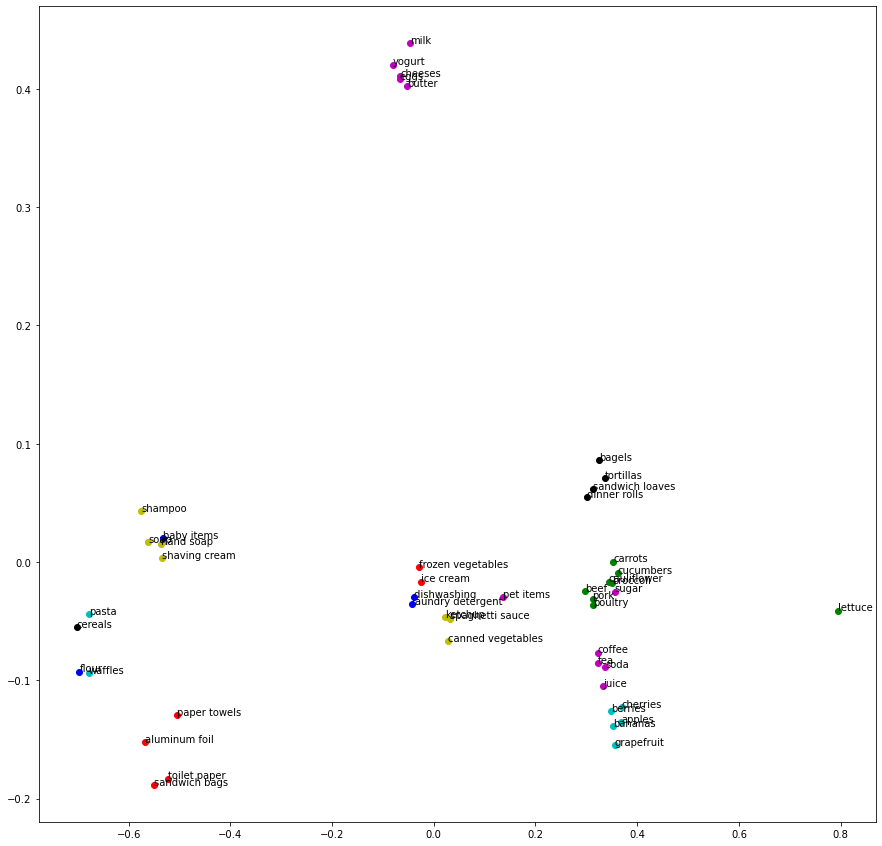

In [26]:
# use all the components
cluster(n_clusters=15)